In [260]:
import os 
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit, minimize
from matplotlib.ticker import FuncFormatter

os.chdir('/Users/louise/Documents/PJTS/ECCE')

**-Context-**

As resolution decreases, information loss increases, and the data become more homogenized.  
We expect that beyond a certain resolution, the available information becomes obsolete and no longer useful for retrieving high-resolution data.

**-Objective-**

Estimate the resolution at which information alone becomes insufficient to reconstruct high-resolution precipitation data, moving us beyond the scope of super-resolution.

To achieve this, we will analyze:  
- **Spatial autocorrelation** (precipitation vs. precipitation)  
- **Cross-correlation** (precipitation vs. DEM, i.e., altitude)  

These analyses will help identify the point at which the resolution degrades to the extent that topographic features no longer provide relevant information.

# 1. Spatial autocorrelation

## 1.1. Create the normalized data set 

We import the precipitation data and create a new field: temporally normalized at each grid point.

In [164]:
df = pd.read_csv('data/0_cluster/TOT_PR/data2_summer_present_HR_v1.csv', usecols=['rlat', 'rlon', 'TOT_PR', 'month', 'year'])

df_normalized = []
unique_coords = df[['rlat', 'rlon']].drop_duplicates().values

for i, (lat, lon) in enumerate(unique_coords, start=1):
    df_local = df[(df['rlat'] == lat) & (df['rlon'] == lon)].copy()
    
    if i in {1, 500, 1000, 10000, 12000, 15000}:
        print(f"[{i}] Mean: {df_local.TOT_PR.mean():.8f}, Std: {df_local.TOT_PR.std():.8f}")
    
    std = df_local.TOT_PR.std()
    if std > 0:
        df_local['TOT_PR'] = (df_local.TOT_PR - df_local.TOT_PR.mean()) / std
    else:
        df_local['TOT_PR'] = 0 

    df_normalized.append(df_local)

df_normalized = pd.concat(df_normalized, ignore_index=True)
df_normalized.head(5)

[1] Mean: 0.00706225, Std: 0.00461084
[500] Mean: 0.00810036, Std: 0.00500786
[1000] Mean: 0.00898709, Std: 0.00547216
[10000] Mean: 0.00651371, Std: 0.00397898
[12000] Mean: 0.00757633, Std: 0.00419450
[15000] Mean: 0.00700664, Std: 0.00411566


,rlon,rlat,TOT_PR,year,month
0,-2.84,-1.2,0.721489,1999,6
1,-2.84,-1.2,-0.809516,1999,7
2,-2.84,-1.2,0.620054,1999,8
3,-2.84,-1.2,1.559128,2000,6
4,-2.84,-1.2,0.511787,2000,7


## 2.2. Computation of the Autocorrelation

In [165]:
def autocovariance (df): # df must contains columns rlat / rlon / TOT_PR
    coords = df[['rlat', 'rlon']].values
    distance_matrix = squareform(pdist(coords, metric='euclidean'))

    max_distance = 100/111  # Conversion de km en degrés approximativement (1 degré ≈ 111 km)
    bins = np.linspace(0, max_distance, num=20)

    mean_tot_pr = df['TOT_PR'].mean()
    var_tot_pr = df['TOT_PR'].var()

    autocorrelation = []

    for k in tqdm.tqdm(range(len(bins) - 1)):
        bin_indices = np.where((distance_matrix >= bins[k]) & (distance_matrix < bins[k + 1]))
        
        if len(bin_indices[0]) > 0:
            covariances = []
            for i, j in zip(bin_indices[0], bin_indices[1]):
                if i < j:  
                    cov = (df['TOT_PR'].iloc[i] - mean_tot_pr) * (df['TOT_PR'].iloc[j]-mean_tot_pr)
                    covariances.append(cov)
            
            avg_cov = np.mean(covariances)
            autocorrelation.append(avg_cov/var_tot_pr)
        else:
            autocorrelation.append(0)  

    distance_centers = (bins[:-1] + bins[1:]) / 2

    return distance_centers, autocorrelation


In [ ]:
dico_auto, dico_dist = {}, {}

for year in range(1999, 2010):
    print(f"Processing of the Year: {year}")
    dico_auto[year], dico_dist[year] = {}, {}

    for month in [6, 7, 8]:
        df_local = df_normalized[(df_normalized.year == year) & (df_normalized.month == month)].copy()
        distances, autocorr = autocovariance(df_local)
        dico_dist[year][month] = distances
        dico_auto[year][month] = autocorr

rows_dist = []
rows_auto = []

for year in range(1999, 2010):
    for month in [6, 7, 8]:
        distances = dico_dist[year][month][:19]
        autocorrs = dico_auto[year][month][:19]
        
        for i, (dist, auto) in enumerate(zip(distances, autocorrs)):
            rows_dist.append({'year': year, 'month': month, 'bin': i, 'value': dist})
            rows_auto.append({'year': year, 'month': month, 'bin': i, 'value': auto})

df_dist = pd.DataFrame(rows_dist)
df_auto = pd.DataFrame(rows_auto)

df_dist = df_dist.pivot(index=['month', 'year'], columns='bin', values='value').reset_index()
df_auto = df_auto.pivot(index=['month', 'year'], columns='bin', values='value').reset_index()

df_dist.to_csv('data/3_Correlations/distance_cross.csv', index=False)
df_auto.to_csv('data/3_Correlations/df_auto.csv', index=False)


Traitement de l'année : 1999
0.009443443311741276 0.813842626360392


100%|██████████| 19/19 [02:35<00:00,  8.21s/it]


0.16073582211795337 1.0841949510424878


100%|██████████| 19/19 [02:36<00:00,  8.23s/it]


0.09318861005275358 0.9097557493606723


100%|██████████| 19/19 [02:35<00:00,  8.16s/it]


Traitement de l'année : 2000
-0.6252045699168514 0.4837486604358943


100%|██████████| 19/19 [02:36<00:00,  8.23s/it]


0.24156836684189625 1.0511502391968934


100%|██████████| 19/19 [02:36<00:00,  8.22s/it]


0.31426989038893066 1.2633438825796617


100%|██████████| 19/19 [02:36<00:00,  8.22s/it]


Traitement de l'année : 2001
-0.21372943140640802 0.6196208681286034


100%|██████████| 19/19 [02:36<00:00,  8.23s/it]


0.052550298131320464 0.9040344612161455


100%|██████████| 19/19 [02:37<00:00,  8.29s/it]


0.19161310224282718 0.9859014695193172


100%|██████████| 19/19 [02:36<00:00,  8.22s/it]


Traitement de l'année : 2002
-0.016852084762224367 0.8321131589681444


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


-0.18938620117083127 0.6454762602053327


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


0.010427516990870665 0.6850007369258664


100%|██████████| 19/19 [02:35<00:00,  8.18s/it]


Traitement de l'année : 2003
0.32189724109959855 1.1488806736102868


100%|██████████| 19/19 [02:36<00:00,  8.21s/it]


0.17317128176282748 1.2887107720901234


100%|██████████| 19/19 [02:35<00:00,  8.18s/it]


0.10440848497682916 1.0519772220796662


100%|██████████| 19/19 [02:36<00:00,  8.22s/it]


Traitement de l'année : 2004
-0.5003742248505227 0.7264881143782173


100%|██████████| 19/19 [02:35<00:00,  8.19s/it]


0.30466832371248814 1.2448913487966307


100%|██████████| 19/19 [02:35<00:00,  8.18s/it]


0.38653346650826964 1.176692971773733


100%|██████████| 19/19 [02:35<00:00,  8.16s/it]


Traitement de l'année : 2005
0.03331980382171019 1.0254019853043508


100%|██████████| 19/19 [02:35<00:00,  8.20s/it]


-0.00892345752672294 0.9565698869682441


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


-0.334401940933681 0.6988039304366461


100%|██████████| 19/19 [02:34<00:00,  8.14s/it]


Traitement de l'année : 2006
-0.04919995205326109 1.070638048424341


100%|██████████| 19/19 [02:34<00:00,  8.14s/it]


-0.05825017332497305 0.9229105145791531


100%|██████████| 19/19 [02:34<00:00,  8.14s/it]


-0.10432880636143108 0.6594934759947005


100%|██████████| 19/19 [02:34<00:00,  8.14s/it]


Traitement de l'année : 2007
0.4633171194115806 0.9767718473775945


100%|██████████| 19/19 [02:35<00:00,  8.19s/it]


-0.010489926203302444 0.8468091332940915


100%|██████████| 19/19 [02:35<00:00,  8.19s/it]


-0.14652517198479698 0.7113571065293288


100%|██████████| 19/19 [02:35<00:00,  8.18s/it]


Traitement de l'année : 2008
-0.5912253753517293 0.5635232494067701


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


0.3756124725766628 1.0575575787113085


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


0.03142610307383095 0.8638020836833266


100%|██████████| 19/19 [02:35<00:00,  8.18s/it]


Traitement de l'année : 2009
-0.40903079074052684 0.4374654567352851


100%|██████████| 19/19 [02:35<00:00,  8.18s/it]


0.11884032328869283 0.9832672735349447


100%|██████████| 19/19 [02:35<00:00,  8.19s/it]


-0.12917757830406143 0.9148699333135601


100%|██████████| 19/19 [02:35<00:00,  8.17s/it]


# 2. Cross-correlation

## 2.1. Import data 

In [187]:
df = pd.read_csv('data/0_cluster/TOT_PR/data2_summer_present_HR_v1.csv', usecols=['rlat', 'rlon', 'TOT_PR', 'month', 'year'])
topo = pd.read_csv('data/0_cluster/Topography/topography_variables.csv', usecols=['rlat', 'rlon', 'alt'])
df = pd.merge(df, topo, on = ['rlat', 'rlon'], how = 'left')

mean_tot_pr = df.TOT_PR.mean()
var_tot_pr = df.TOT_PR.var()
mean_alt = df.alt.mean()
var_alt = df.alt.var()

## 2.2. Computation of the Cross-correlation (precip - altitude)

In [ ]:
def cross_covariance(df, mean_tot_pr, var_tot_pr, mean_alt, var_alt): # df must contains columns rlat / rlon / TOT_PR / alt

    coords = df[['rlat', 'rlon']].values
    distance_matrix = squareform(pdist(coords, metric='euclidean'))

    max_distance = 100 / 111
    bins = np.linspace(0, max_distance, num=40)

    cross_correlation = []

    for k in tqdm.tqdm(range(len(bins) - 1)):
        bin_indices = np.where((distance_matrix >= bins[k]) & (distance_matrix < bins[k + 1]))
        
        if len(bin_indices[0]) > 0:
            covariances = []
            for i, j in zip(bin_indices[0], bin_indices[1]):
                if i < j:  
                    cov = (df['TOT_PR'].iloc[i] - mean_tot_pr) * (df['alt'].iloc[j] - mean_alt)
                    covariances.append(cov)
            
            avg_cov = np.mean(covariances)
            cross_correlation.append(avg_cov/ (np.sqrt(var_tot_pr * var_alt)))
        else:
            cross_correlation.append(0)

    distance_centers = (bins[:-1] + bins[1:]) / 2

    return distance_centers, cross_correlation

In [ ]:
dico_auto, dico_dist = {}, {}

for year in range(1999, 2010):
    print(f"Processing of the Year: {year}")
    dico_auto[year], dico_dist[year] = {}, {}

    for month in [6, 7, 8]:
        df_local = df[(df.year == year) & (df.month == month)].copy()
        distances, autocorr = cross_covariance(df_local, mean_tot_pr, var_tot_pr, mean_alt, var_alt)
        dico_dist[year][month] = distances
        dico_auto[year][month] = autocorr

rows_dist = []
rows_auto = []

for year in range(1999, 2010):
    for month in [6, 7, 8]:
        distances = dico_dist[year][month][:39]
        autocorrs = dico_auto[year][month][:39]
        
        for i, (dist, auto) in enumerate(zip(distances, autocorrs)):
            rows_dist.append({'year': year, 'month': month, 'bin': i, 'value': dist})
            rows_auto.append({'year': year, 'month': month, 'bin': i, 'value': auto})

df_dist = pd.DataFrame(rows_dist)
df_auto = pd.DataFrame(rows_auto)
df_dist = df_dist.pivot(index=['month', 'year'], columns='bin', values='value').reset_index()
df_auto = df_auto.pivot(index=['month', 'year'], columns='bin', values='value').reset_index()

df_dist.to_csv('data/3_Correlations/distance_centers_cross.csv', index=False)
df_auto.to_csv('data/3_Correlations/df_cross.csv', index=False)


Processing of the Year: 1999


100%|██████████| 39/39 [02:51<00:00,  4.40s/it]


Processing of the Year: 2000


100%|██████████| 39/39 [02:51<00:00,  4.39s/it]


Processing of the Year: 2001


100%|██████████| 39/39 [02:51<00:00,  4.39s/it]


Processing of the Year: 2002


100%|██████████| 39/39 [02:53<00:00,  4.44s/it]


Processing of the Year: 2003


100%|██████████| 39/39 [02:51<00:00,  4.40s/it]


Processing of the Year: 2004


100%|██████████| 39/39 [02:50<00:00,  4.37s/it]


Processing of the Year: 2005


100%|██████████| 39/39 [02:50<00:00,  4.36s/it]


Processing of the Year: 2006


100%|██████████| 39/39 [02:50<00:00,  4.38s/it]


Processing of the Year: 2007


100%|██████████| 39/39 [02:51<00:00,  4.41s/it]


Processing of the Year: 2008


100%|██████████| 39/39 [2:18:42<00:00, 213.39s/it]  


Processing of the Year: 2009


100%|██████████| 39/39 [02:50<00:00,  4.38s/it]


# 3. Visualisations

Generate visual representations of the correlations to better interpret the results and identify the resolution threshold where the information becomes unreliable.

In [ ]:
distance_centers_cross = pd.read_csv('data/3_Correlations/distance_centers_cross.csv')
distance_centers_cross = distance_centers_cross.loc[(distance_centers_cross.year == 1999) & (distance_centers_cross.month == 6), [str(x) for x in range(39)]].values
distance_centers_cross = distance_centers_cross[0]

distance_centers = pd.read_csv('data/3_Correlations/distance_cross.csv')
distance_centers = distance_centers.loc[(distance_centers.year == 1999) & (distance_centers.month == 6), [str(x) for x in range(19)]].values
distance_centers = distance_centers[0]

In [ ]:
df_auto = pd.read_csv('data/3_Correlations/df_auto.csv')
df_cross = pd.read_csv('data/3_Correlations/df_cross.csv')

df_auto.columns = [int(col) if str(col).isdigit() else col for col in df_auto.columns]
df_cross.columns = [int(col) if str(col).isdigit() else col for col in df_cross.columns]

liste_moyenne_auto = []
liste_moyenne_cross = []

for _ in range(19):
    liste_moyenne_auto.append(np.mean(df_auto[_]))

for _ in range(39):
    liste_moyenne_cross.append(np.mean(df_cross[_]))

liste_auto_x = []
liste_auto_y = []

distance_centers0 = [0] + list(distance_centers)
for _, __ in zip(range(19), distance_centers0) :
    liste_auto_y += list(df_auto[_])
    liste_auto_x += list([__]*len(df_auto[_]))

In [205]:
def figures_plots (name):
    df_block = pd.read_csv("data/0_cluster/Topography/"+name)[['rlat', 'rlon', 'block']]
    df_block = df_block.loc[df_block.block == 0]
    df_block.reset_index(inplace = True)

    liste_rlat = df_block['rlat'].unique()
    liste_rlon = df_block['rlon'].unique()
    liste = []

    for lat in sorted(liste_rlat)[:int(len(liste_rlat)/2)]:
        for lon in sorted(liste_rlon)[:int(len(liste_rlon)/2)]:
            for i, row in df_block.iterrows():
                liste.append(np.sqrt((row['rlat'] - lat)**2 + (row['rlon'] - lon)**2))
    
    return liste

x_12 = np.max(figures_plots('grille2_12.csv'))
x_24 = np.max(figures_plots('grille2_24.csv'))
x_48 = np.max(figures_plots('grille2_48.csv'))

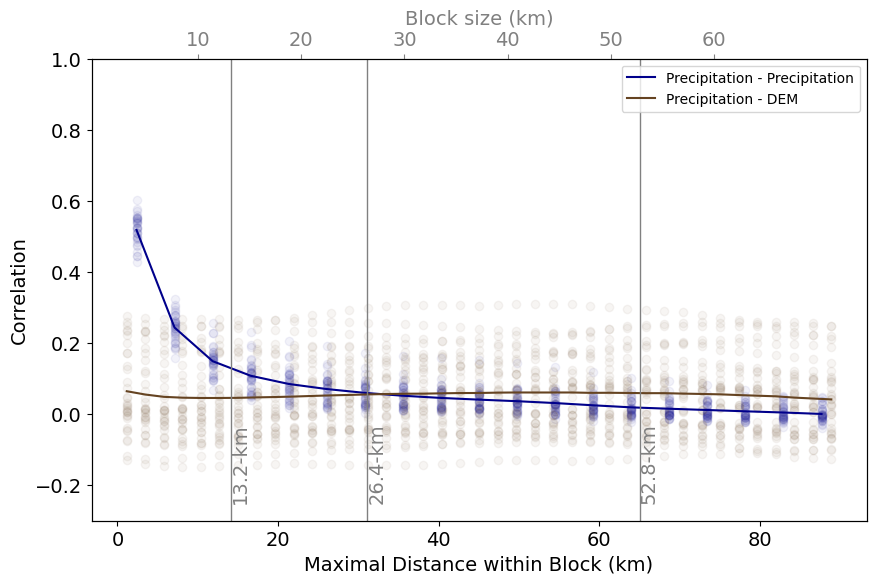

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for i, row in df_auto.iterrows():
    plt.scatter(distance_centers, df_auto.loc[i, range(19)], color='darkblue', alpha=0.05)

for i, row in df_cross.iterrows():
    plt.scatter(distance_centers_cross, df_cross.loc[i, range(39)], color='#654321', alpha=0.05)

ax.plot(distance_centers, liste_moyenne_auto[:19], color='darkblue', label = 'Precipitation - Precipitation')
ax.plot(distance_centers_cross, liste_moyenne_cross, color='#654321', label = 'Precipitation - DEM')

for x, label in zip([x_12, x_24, x_48], ['13.2-km', '26.4-km', '52.8-km']):
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=1)
    ax.text(x, -0.25, label, rotation=90, verticalalignment='bottom', color='gray', fontsize=14)


ax.set_xlabel("Maximal Distance within Block (km)")
ax.set_ylabel("Correlation")
ax.set_ylim(-0.3, 1)
ax.legend()

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

ll = []
for i in [10, 20, 30, 40, 50, 60]:
    ll.append(np.sqrt((0.02 * ((i/1.1)/2 - 1))**2 *2))
    #ll.append(np.sqrt((0.02 * (i/2 - 1))**2 *2))

ax2.set_xticks(ll)
ax2.set_xticklabels([10, 20, 30, 40, 50, 60], color='gray')
ax2.tick_params(axis='x', colors='gray')
ax2.set_xlabel("Block size (km)", color='gray')

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}'))

plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.show()

## 3.1. Modeling of Correlation Curves

The average of the auto-correlation curves shows a clear decreasing trend, resembling an exponential decay. In contrast, the cross-correlation remains relatively constant across distances and will therefore be fitted with a constant function.

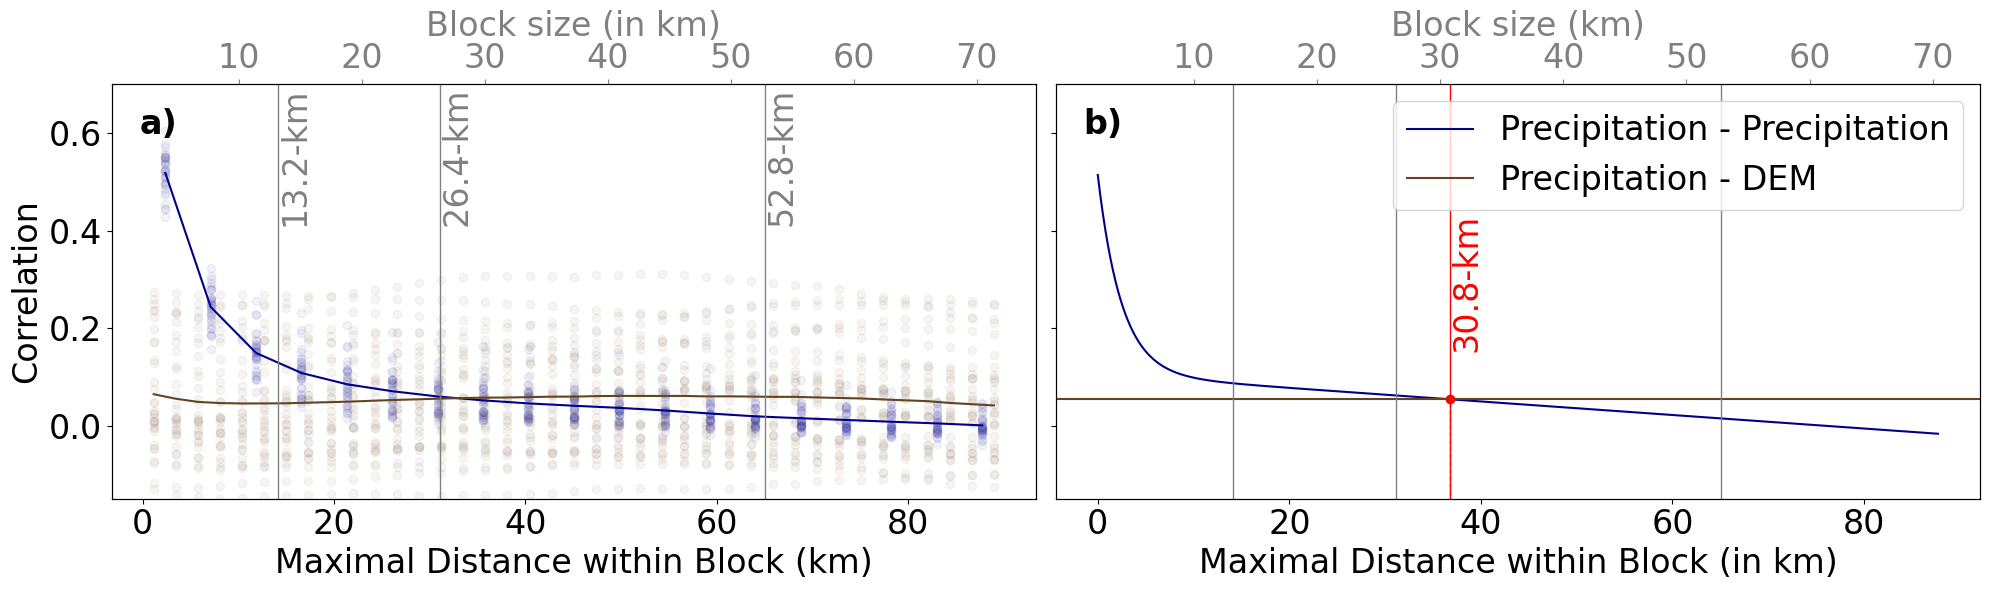

In [262]:
text_size = 24
points_x = np.linspace(0.00001, distance_centers[-1], 1000)


fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# ----------------------------
# PREMIER GRAPHIQUE 
# ----------------------------
ax = axs[0]
#ax.set_title('a)', loc='left', fontsize=text_size)
ax.text(0.03, 0.88, "a)", transform=ax.transAxes, fontsize=text_size, fontweight='bold')

for i, row in df_auto.iterrows():
    ax.scatter(distance_centers, df_auto.loc[i, range(19)], color='darkblue', alpha=0.05)

for i, row in df_cross.iterrows():
    ax.scatter(distance_centers_cross, df_cross.loc[i, range(39)], color='#654321', alpha=0.05)

ax.plot(distance_centers, liste_moyenne_auto[:19], color='darkblue')#, label='Precipitation - Precipitation')
ax.plot(distance_centers_cross, liste_moyenne_cross, color='#654321')#, label='Precipitation - DEM')

# LIGNES GRISES 
for x, label in zip([x_12, x_24, x_48], ['13.2-km', '26.4-km', '52.8-km']):
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=1)
    ax.text(x, 0.41, label, rotation=90, verticalalignment='bottom', color='gray', fontsize=text_size)

ax.set_xlabel("Maximal Distance within Block (km)", fontsize=text_size)
ax.set_ylabel("Correlation", fontsize=text_size)
ax.set_ylim(-0.15, 0.7)
#ax.legend(fontsize=text_size)  # Augmente la taille des légendes
ax.tick_params(axis='both', labelsize=text_size)  # Augmente la taille des tirets

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

ll = []
for i in [10, 20, 30, 40, 50, 60, 70]:
    ll.append(np.sqrt((0.02 * ((i/1.1)/2 - 1))**2 *2))

ax2.set_xticks(ll)
ax2.set_xticklabels([10, 20, 30, 40, 50, 60, 70], fontsize=text_size, color='gray')
ax2.tick_params(axis='x', labelsize=text_size, colors='gray')
ax2.set_xlabel("Block size (in km)", fontsize=text_size, color='gray')

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}'))
#ax.text(0.95, 0.9, "(a)", transform=ax[0].transAxes, fontsize=text_size, fontweight='bold')


# ----------------------------
# DEUXIÈME GRAPHIQUE (droite)
# ----------------------------

ax = axs[1]
#ax.set_title('b)', loc='left', fontsize=text_size)
ax.text(0.03, 0.88, "b)", transform=ax.transAxes, fontsize=text_size, fontweight='bold')

# PRECIP-PRECIP
def exp_decay(x, a, b, c, d):
    return a * np.exp(-b * x) + c * x + d

def weighted_cost(params, x, y):
    a, b, c, d = params
    y_pred = exp_decay(x, a, b, c, d)
    return np.sum((y - y_pred) ** 2)

initial_params = [0.1, 100, -0.2, -0.5]
optimal_params = minimize(weighted_cost, initial_params, args=(np.array(liste_auto_x), np.array(liste_auto_y)), method='L-BFGS-B').x
fitted_curve_black = exp_decay(np.array(points_x), *optimal_params)
ax.plot(points_x, fitted_curve_black, color='darkblue', linestyle='-', label='Precipitation - Precipitation')

# PRECIP-ELEVATION
def constant(x, b):
    return b

params_red, _ = curve_fit(constant, points_x, liste_moyenne_cross[1:49])
fitted_curve_red = constant(points_x, *params_red)
ax.axhline(y=np.mean(df_cross[range(1, 39)]), color='#654321', linestyle='-', label='Precipitation - DEM')

# INTERSECTION 
intersection_index = np.argmin(np.abs(fitted_curve_red - fitted_curve_black))
intersection_distance = points_x[intersection_index]
intersection_value = fitted_curve_black[intersection_index]
ax.scatter(intersection_distance, intersection_value, color='red', zorder=5)

ax.plot([intersection_distance, intersection_distance], [-0.4, intersection_value], color='red', linestyle='--', linewidth=1)


# LIGNES GRISES 
for x, label in zip([x_12, x_24, x_48], ['13.2-km', '26.4-km', '52.8-km']):
    ax.axvline(x=x, color='gray', linestyle='-', linewidth=1)
    #ax.text(x, -0.25, label, rotation=90, verticalalignment='bottom', color='gray', fontsize=14)

ax.axvline(x=intersection_distance, color='red', linestyle='-', linewidth=1)

y = intersection_distance**2 
y = y/2
y = np.sqrt(y) / 0.02
y += 1
y = y * 2
y = y *1.1


ax.text(intersection_distance, 0.15, str(round(y, 1))+'-km', rotation=90, verticalalignment='bottom', color='red', fontsize=text_size)

ax.set_xlabel("Maximal Distance within Block (in km)", fontsize=text_size)
ax.set_ylim(-0.15, 0.7)
ax.legend(fontsize=text_size)  # Augmente la taille des légendes
ax.tick_params(axis='both', labelsize=text_size)  # Augmente la taille des tirets

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())

ll = []
for i in [10, 20, 30, 40, 50, 60, 70]:
    ll.append(np.sqrt((0.02 * ((i/1.1)/2 - 1))**2 *2))

ax2.set_xticks(ll)
ax2.set_xticklabels([10, 20, 30, 40, 50, 60, 70], fontsize=text_size, color='gray')
ax2.tick_params(axis='x', labelsize=text_size, colors='gray')
ax2.set_xlabel("Block size (km)", fontsize=text_size, color='gray')

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}'))

plt.savefig("Figures_End/Fig_7.pdf", format='pdf', dpi = 300)

plt.tight_layout()
plt.show()